In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# For use on local machine
%cd ..

/


In [2]:
# For use in google colab
!git clone https://github.com/mtzig/LIDC_GDRO.git
%cd LIDC_GDRO/

fatal: destination path 'LIDC_GDRO' already exists and is not an empty directory.
/content/LIDC_GDRO


In [3]:
!git pull

Already up to date.


In [4]:
import data_util
import datasets
import dataloaders
import models
import torch
import loss
import train
import pandas as pd
import numpy as np
import torchvision

In [5]:
class TransferModel18(torch.nn.Module):

    def __init__(self, pretrained=True, freeze=True, binary = True, device='cpu'):
        super(TransferModel18, self).__init__()

        self.model = torchvision.models.resnet18(pretrained=pretrained).to(device)
        
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False


            # for param in self.model.layer4.parameters():
            #     param.requires_grad = True
        
        out_feats = 2 if binary else 4
        self.model.fc = torch.nn.Sequential(
          torch.nn.Linear(in_features=512, out_features=36, bias=True, device=device),
          torch.nn.ReLU(inplace=True),
          # nn.Dropout(p=0.5, inplace=False),
          torch.nn.Linear(in_features=36, out_features=out_feats, bias=True, device=device)
        )

        for layer in self.model.fc:
            if hasattr(layer, 'weight'):
                torch.nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        return self.model(x).squeeze()


class TransferModel50(torch.nn.Module):

    def __init__(self, pretrained=True, freeze=True, binary = True, device='cpu'):
        super(TransferModel50, self).__init__()

        self.model = torchvision.models.resnet50(pretrained=pretrained).to(device)
        
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False


            # for param in self.model.layer4.parameters():
            #     param.requires_grad = True
        
        out_feats = 2 if binary else 4
        self.model.fc = torch.nn.Sequential(
          torch.nn.Linear(in_features=2048, out_features=out_feats, bias=True, device=device),
        )

        for layer in self.model.fc:
            if hasattr(layer, 'weight'):
                torch.nn.init.xavier_uniform_(layer.weight)

    def forward(self, x):
        return self.model(x).squeeze()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"

training_fraction = 0.8
batch_size = 128
proportional = True

is_gdro = True

hparams = {"eta": 0.01, "gamma": 1}
lr = 0.001
weight_decay = 0.0001
momentum = 0.9

model_class = TransferModel50
model_args = (True, False, True, device)


device

'cuda'

# Load and process data

## LIDC

In [ ]:
# get LIDC data

df = data_util.preprocess_data(*data_util.load_lidc())
df

ValueError: ignored

In [ ]:
# get train/test flags
train_test = pd.read_csv("data/lidc_train_test_split_stratified.csv")

# create train/test dataframes
training_df = df[df["noduleID"].isin(train_test[train_test["dataset"] == "train"]["noduleID"].values)]
test_df = df[df["noduleID"].isin(train_test[train_test["dataset"] == "test"]["noduleID"].values)]

## Waterbirds

In [ ]:
# download waterbirds through wilds

!pip install wilds
from wilds import get_dataset

get_dataset(dataset="waterbirds", download=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from PIL import Image

In [8]:
metadata_df = pd.read_csv('data/waterbirds_v1.0/metadata.csv')

In [9]:
from torchvision import transforms
class OnDemandWaterbirdsDataset(torch.utils.data.Dataset):
    def __init__(self, metadata, root_dir, transform, device):
        '''
        INPUTS:
        metadata: metadata dataframe storing the image paths, labels, and subclasses
        root_dir: the directory where the image files are stored
        transform: the transform to apply to the image when it is loaded
        device to move tensors to as they are loaded

        '''

        self.metadata = metadata
        self.root_dir = root_dir
        self.transform = transform
        self.device = device

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # column 1: image path
        img_path = self.metadata.iloc[idx, 1]
        img_tensor = self.transform(Image.open(self.root_dir + img_path)).squeeze().to(self.device)

        # column 2: image label
        label = torch.LongTensor([self.metadata.iloc[idx, 2]]).squeeze().to(self.device)

        # column 4 contains the confounding label, which is combined with column 2 to get the subclass
        subclass = torch.LongTensor([2 * self.metadata.iloc[idx, 2] + self.metadata.iloc[idx, 4]]).squeeze().to(self.device)

        return img_tensor, label, subclass

In [10]:
convert_resize = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), torchvision.transforms.Resize((200, 200), antialias=True)])

train_df, val_df, test_df = [metadata_df[metadata_df['split'] == split] for split in [0, 1, 2]]

dataset_list = []

for df in [train_df, val_df, test_df]:
    dataset_list.append(OnDemandWaterbirdsDataset(df, 'data/waterbirds_v1.0/', transform=convert_resize, device=device))

In [11]:
# smaller dataloaders for prototyping
train_dataloader, test_dataloader, _ = [dataloaders.InfiniteDataLoader(torch.utils.data.Subset(dataset, range(0, len(dataset), 2)), batch_size=batch_size) for dataset in dataset_list]

In [ ]:
# full size dataloaders
train_dataloader, test_dataloader, _ = [dataloaders.InfiniteDataLoader(dataset, batch_size=batch_size) for dataset in dataset_list]


# Test convergence of combinations of ERM and GDRO

In [12]:
N = 1
epochs = 15
# subtypes = ["Overall", "Unspiculated benign", "Spiculated benign", "Spiculated malignant", "Unspiculated malignant"]
subtypes = ["Overall", "Land on land", "Land on water", "Water on land", "Water on water"]

# test_algorithms = ["ERM", "GDRO", "Sharp", "Smooth", "ReverseSmooth", "Dynamic", "ExtraERM", "ExtraGDRO", "Halfway"]
# test_algorithms = ["Mix" + str(t) for t in [0.4, 0.5, 0.6, 0.7, 0.8]]
# test_algorithms = ["ERM", "GDRO", *["Dynamic" + str(t) for t in [0.01, 0.05, 0.1, 0.5]]]
test_algorithms = ["ERM", "GDRO", "Dynamic", "Upweight"]
keep_old =        [True, True, True, False]

In [15]:
if not sum(keep_old):
  results = {}

for a in range(len(test_algorithms)):
    algorithm = test_algorithms[a]

    if keep_old[a] and algorithm in results:
      print(f"Keeping old results for {algorithm}")
    else:
      print(f"Running test: {algorithm}")

      results[algorithm] = np.zeros(N * epochs * len(subtypes))

      # create the training and testing dataloaders
  #     if algorithm == "ERM":
  #         train_dataloader = data_util.create_dataloader(training_df, batch_size)
  #     else:
  #         train_dataloader = data_util.create_subtyped_dataloader(training_df, subtype_df, batch_size, proportional)
  #     test_dataloader = data_util.create_subtyped_dataloader(test_df, subtype_df, batch_size, proportional)
      
      # train_dataloader = data_util.create_dataloader(training_df, batch_size)
      # test_dataloader = data_util.create_dataloader(test_df, batch_size)

      for n in range(N):

          print(f"Trial {n + 1}/{N}")

          # create and train model
          # model = models.NeuralNetwork(64, 32, 32, 2)
          # model.to(device)
          model = model_class(*model_args)

          if (algorithm == "ERM"):
              loss_fn = loss.ERMLoss(model, torch.nn.CrossEntropyLoss(), hparams, subclassed=True)
          elif (algorithm == "GDRO"):
              loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), hparams["eta"], 4, normalize_loss=False)
          elif (algorithm.startswith("GDRO")):
              loss_fn = loss.GDROLossAlt(model, torch.nn.CrossEntropyLoss(), float(algorithm[len("GDRO"):]), 4, normalize_loss=True)
          elif (algorithm == "Dynamic"):
              loss_fn = loss.DynamicERMGDROLossAlt(model, torch.nn.CrossEntropyLoss(), hparams["eta"], hparams["gamma"], 4)
          elif (algorithm.startswith("Dynamic")):
              loss_fn = loss.DynamicERMGDROLossAlt(model, torch.nn.CrossEntropyLoss(), float(algorithm[len("Dynamic"):]), hparams["gamma"], 4)
          elif (algorithm == "Upweight"):
              loss_fn = loss.UpweightSmall(model, torch.nn.CrossEntropyLoss(), 4)
          else:
              loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, 4)
          optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay, momentum=momentum)

          for epoch in range(epochs):
              print(f'Epoch {epoch + 1} / {epochs}')

              if algorithm == "Sharp":
                  loss_fn.t = epoch / epochs < 0.5  # sharp boundary
              elif algorithm == "Smooth":
                  loss_fn.t = 1 - (epoch / (epochs - 1))  # linear interpolation
              elif algorithm == "ReverseSmooth":
                  loss_fn.t = epoch / (epochs - 1)  # reverse linear interpolation
              elif algorithm == "ExtraERM":
                  loss_fn.t = 2
              elif algorithm == "ExtraGDRO":
                  loss_fn.t = -1
              elif algorithm == "Halfway":
                  loss_fn.t = 0.5
              elif algorithm.startswith("Mix"):
                  loss_fn.t = float(algorithm[3:])  # ex. algorithm == "Mix0.5" => t = 0.5

              train.train(train_dataloader, model, loss_fn, optimizer)
              sensitivities = train.test(test_dataloader, model)
              print(sensitivities)

              for i in range(len(subtypes)):
                  results[algorithm][n * epochs * len(subtypes) + epoch * len(subtypes) + i] = sensitivities[i]

print("Test complete")

Keeping old results for ERM
Keeping old results for GDRO
Keeping old results for Dynamic
Running test: Upweight
Trial 1/1


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1 / 15
(0.861328125, 0.8677248677248677, 0.9241071428571429, 0.6739130434782609, 0.7358490566037735)
Epoch 2 / 15
(0.390625, 0.28901734104046245, 0.21551724137931033, 0.9814814814814815, 0.8867924528301887)
Epoch 3 / 15
(0.650390625, 0.7553191489361702, 0.4786729857819905, 0.6363636363636364, 0.9482758620689655)
Epoch 4 / 15
(0.86328125, 0.98, 0.8894472361809045, 0.3541666666666667, 0.8)
Epoch 5 / 15
(0.80859375, 0.9315789473684211, 0.705, 0.7727272727272727, 0.8035714285714286)
Epoch 6 / 15
(0.828125, 0.9625668449197861, 0.8480392156862745, 0.5072463768115942, 0.6923076923076923)
Epoch 7 / 15
(0.82421875, 0.9365853658536586, 0.7067307692307693, 0.7906976744186046, 0.875)
Epoch 8 / 15
(0.884765625, 0.9552238805970149, 0.867579908675799, 0.6428571428571429, 0.88)
Epoch 9 / 15
(0.869140625, 0.9833333333333333, 0.8254716981132075, 0.6296296296296297, 0.8939393939393939)
Epoch 10 / 15
(0.869140625, 0.989010989010989, 0.821917808219178, 0.5882352941176471, 0.9166666666666666)
Epoch 11

In [16]:
results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([range(N), range(epochs), subtypes], names=["trial", "epoch", "subtype"]))

In [17]:
trial_means = results_df.unstack().unstack().mean().unstack(level=0).unstack(level=1).stack()
worst_group = trial_means.unstack(level=1).min().unstack(level=0)
worst_group.index = pd.MultiIndex.from_product([["Worst"], worst_group.index], names=["subtype", "epoch"])
worst_concat = pd.concat([trial_means.unstack(level=1).stack(), worst_group])
worst_concat

ERM      GDRO   Dynamic  Upweight
subtype      epoch                                        
Land on land 0      0.988636  0.984293  0.941176  0.867725
             1      0.994764  0.931937  0.979275  0.289017
             2      1.000000  0.994505  0.985366  0.755319
             3      1.000000  0.988764  0.994536  0.980000
             4      1.000000  0.988571  0.993827  0.931579
...                      ...       ...       ...       ...
Worst        10     0.320755  0.709677  0.375000  0.500000
             11     0.385965  0.656109  0.380952  0.400000
             12     0.342105  0.712446  0.312500  0.523810
             13     0.482143  0.700000  0.448276  0.510204
             14     0.452830  0.716346  0.478261  0.537037

[90 rows x 4 columns]

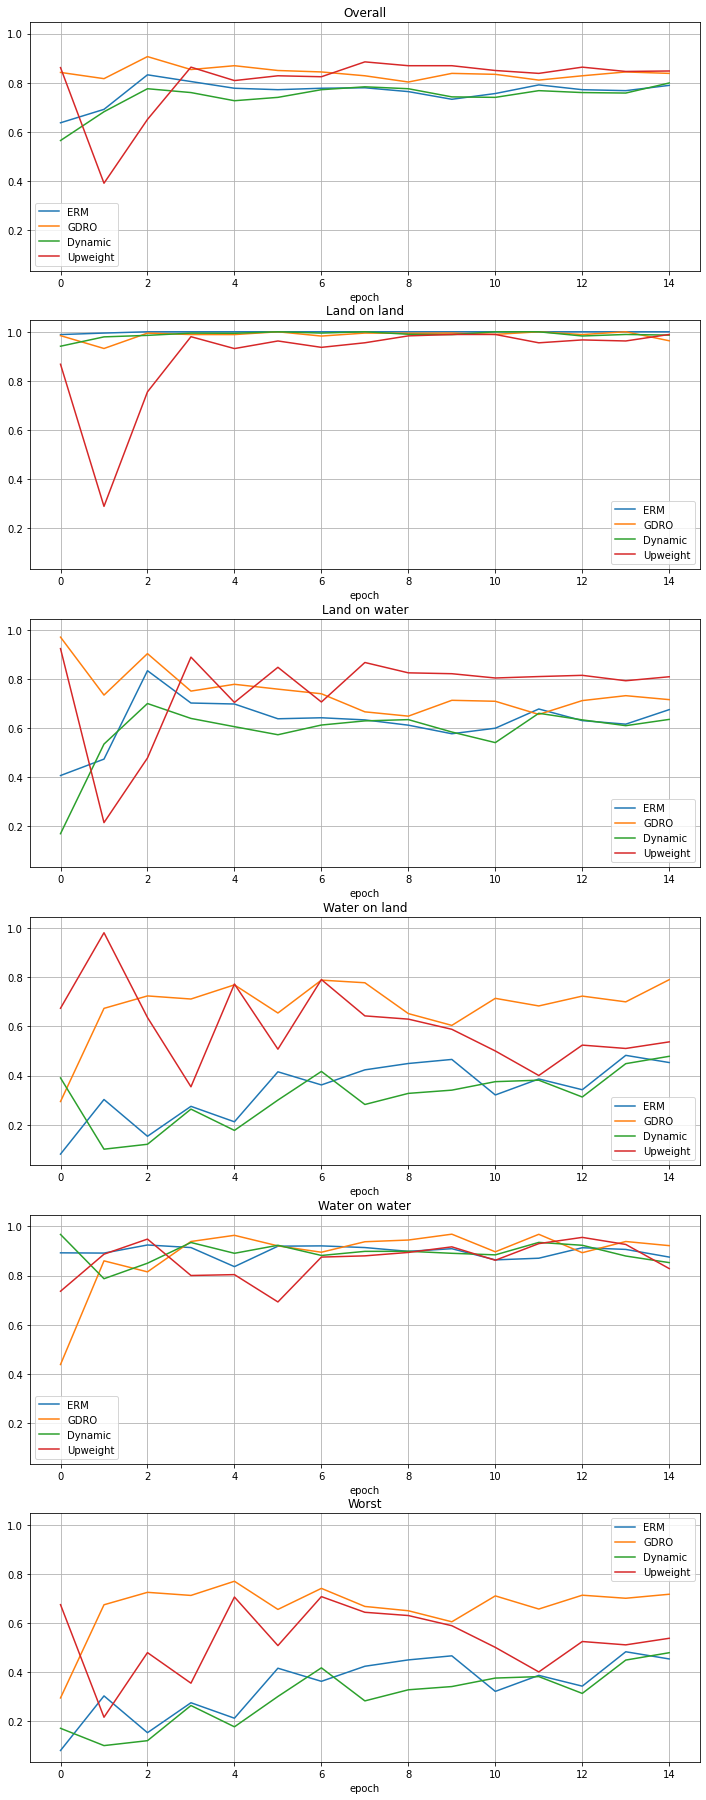

In [18]:
import matplotlib.pyplot as plt

rolling_window = 1

rolling_data = worst_concat.unstack(level=0).rolling(rolling_window).mean().unstack().unstack(level=0)

plots = [*subtypes, "Worst"]

hide = []

f, a = plt.subplots(len(plots),1, sharey=True)
# plot subtypes sensitivity
for i in range(len(plots)):
    rolling_data.drop(columns=hide).rolling(rolling_window).mean().xs(plots[i]).plot(kind='line',title=plots[i],ax=a[i],figsize=(12,32),grid=True)

In [19]:
# save results
results_df.to_csv('test_results/waterbirds_resnet50_200x200_halfdata.csv')

In [13]:
results = pd.read_csv('test_results/waterbirds_resnet50_200x200_halfdata.csv').drop(columns=["subtype", "epoch", "trial"]).to_dict('list')

# GDRO Demonstration

In [ ]:
epochs = 30
N = 1

q_data = {}

for n in range(N):

    q_data[f'Trial_{n}'] = []
    
    model = model_class(*model_args)

    loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams, len(subtypes) - 1, normalize_loss=True, subclassed=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    loss_fn.t = 0

    q_data[f'Trial_{n}'].extend([1 / (len(subtypes) - 1) for i in range(len(subtypes) - 1)])
    for epoch in range(epochs):
        train.train(train_dataloader, model, loss_fn, optimizer)
        q_data[f'Trial_{n}'].extend(loss_fn.gdro.q.tolist())

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
q_df = pd.DataFrame(q_data, index=pd.MultiIndex.from_product([range(epochs + 1), subtypes[1:]], names=['epoch', 'subtype'])).mean(axis=1).unstack()
# columns get rearranged into alphabetical order, this swaps them back
q_df = q_df[subtypes[1:]]

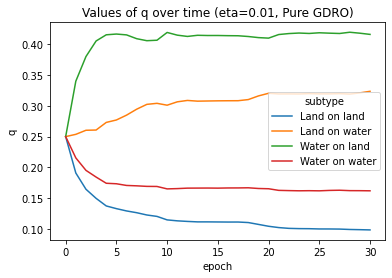

In [ ]:
q_df.plot(xlabel="epoch", ylabel="q", title=f"Values of q over time (eta={hparams['groupdro_eta']}, Pure GDRO)")

# Combining CNN features and engineered features

In [ ]:
cnn_df = pd.read_csv('data/cnn_features.csv')
for c in range(2, len(cnn_df.columns)):
    cnn_df.columns.values[c] = f'CNN_{cnn_df.columns.values[c]}'

eng_df = pd.read_csv('data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv')

In [ ]:
cnn_df = cnn_df[cnn_df['nodule_id'].isin(np.intersect1d(cnn_df['nodule_id'].values, eng_df['noduleID'].values))]
eng_df = eng_df[eng_df['noduleID'].isin(np.intersect1d(cnn_df['nodule_id'].values, eng_df['noduleID'].values))]

In [ ]:
concat_df = eng_df.copy()

In [ ]:
cnn_df.index = cnn_df['nodule_id']
for i in concat_df.index:
    for col in cnn_df.columns[2:]:
        concat_df.at[i, col] = cnn_df.at[concat_df.at[i, 'noduleID'], col]

In [ ]:
concat_df.drop(columns='Unnamed: 0').to_csv('data/AllFeatures2D_MaxSlice_with_CNN.csv', index=False)

,InstanceID,StudyInstanceUID,SeriesInstanceUid,RadiologistID,noduleID,DicomImage,FilePath,subtlety,internalStructure,calcification,...,CNN_27,CNN_28,CNN_29,CNN_30,CNN_31,CNN_32,CNN_33,CNN_34,CNN_35,CNN_36
0,4,1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288...,1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636...,1,1,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0001\1.3.6.1....,5,1,6,...,-5.395743,1.582677,-4.063280,-5.070021,3.163702,5.290330,-2.523472,3.713529,-0.649701,4.314638
1,75,1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160...,1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417...,4,2,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0002\1.3.6.1....,1,1,6,...,-5.850334,5.002493,-3.661947,-3.624461,3.235335,-3.922062,-2.210064,6.059101,-0.500276,5.508437
2,134,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,4,3,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,5,1,6,...,-4.822973,2.920556,-5.047228,-5.552570,3.489042,0.851557,-2.870659,6.073289,-0.647323,6.486247
3,143,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,4,4,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,3,1,6,...,-7.574823,7.260141,-6.138217,-6.386428,4.904528,-2.540447,-2.647656,8.163655,-0.035022,8.056358
4,118,1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276...,1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615...,3,5,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,4,1,6,...,-7.165000,6.356084,-6.882338,-5.712488,5.102713,-2.921033,-2.749318,9.136231,-0.171229,8.867806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2681,30321,1.3.6.1.4.1.14519.5.2.1.6279.6001.112366982107...,1.3.6.1.4.1.14519.5.2.1.6279.6001.265453131727...,2,2686,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0770\1.3.6.1....,5,1,6,...,-4.363398,1.216722,-3.386296,-4.855748,2.966221,5.028000,-2.105534,4.931665,-0.734520,4.226719
2682,32539,1.3.6.1.4.1.14519.5.2.1.6279.6001.213747445868...,1.3.6.1.4.1.14519.5.2.1.6279.6001.232071262560...,2,2687,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0815\1.3.6.1....,4,1,6,...,-5.684091,4.747817,-3.803551,-3.821561,3.346258,-2.903088,-2.005761,5.487472,-0.402588,5.502116
2683,35559,1.3.6.1.4.1.14519.5.2.1.6279.6001.323769537371...,1.3.6.1.4.1.14519.5.2.1.6279.6001.299806338046...,4,2688,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0871\1.3.6.1....,4,1,6,...,0.528109,-2.443759,3.613519,5.157967,-0.401557,-2.264581,4.815277,-1.387713,-0.522287,-1.254572
2684,37212,1.3.6.1.4.1.14519.5.2.1.6279.6001.232772963487...,1.3.6.1.4.1.14519.5.2.1.6279.6001.338875090785...,4,2689,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0916\1.3.6.1....,1,1,6,...,1.710828,-2.952641,4.176023,7.256946,-0.778750,-2.928508,6.510663,-2.376418,-0.569608,-1.775246


In [ ]:
# code to get max slice data from the all slices set

# all_slices = pd.read_csv('data/LIDC_20130817_AllFeatures2D_AllSlices_MattEdited.csv')
# max_slices = []

# nodule_radiologist_pairings = set(zip(all_slices["RadiologistID"], all_slices["noduleID"]))

# for radiologist_id, nodule_id in nodule_radiologist_pairings:
#     nodule_data = all_slices.loc[(all_slices["RadiologistID"] == radiologist_id) & (all_slices["noduleID"] == nodule_id), :]
    
#     max_slice = nodule_data.iloc[np.argmax(nodule_data["Area"]), :]
#     max_slices.append(max_slice)

# max_slice_df = pd.DataFrame(max_slices).sort_values(["noduleID", "RadiologistID"], axis=0).reset_index().drop(columns="index")
# max_slice_df

In [ ]:
maxslice_df = pd.read_csv('data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv')

In [ ]:
correct_semantic_df = pd.read_csv('data/LIDC_labels.csv')

In [ ]:
correct_semantic_df.index = correct_semantic_df['noduleID'].values

In [ ]:
for i in maxslice_df.index:
  maxslice_df.loc[i, ['subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'malignancy']] = correct_semantic_df.loc[maxslice_df.at[i, 'noduleID'], ['subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'malignancy']].values

In [ ]:
maxslice_df[['subtlety', 'internalStructure', 'calcification', 'sphericity', 'margin', 'lobulation', 'spiculation', 'texture', 'malignancy']]

,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy
0,5,1.0,6.0,3,4,3,5,5,5.0
1,2,1.0,6.0,4,2,1,1,2,5.0
2,5,1.0,6.0,4,3,2,2,4,5.0
3,4,1.0,6.0,4,4,1,2,5,4.0
4,4,1.0,6.0,5,5,1,1,5,4.0
...,...,...,...,...,...,...,...,...,...
2682,4,1.0,6.0,2,5,2,2,4,4.0
2683,3,1.0,6.0,3,4,1,1,5,2.0
2684,3,1.0,6.0,5,4,1,1,4,2.0
2685,5,1.0,6.0,3,5,3,2,5,5.0


,subtlety,internalStructure,calcification,sphericity,margin,lobulation,spiculation,texture,malignancy
0,5,1,6,3,3,3,4,5,5.0
1,1,1,6,3,2,1,1,2,5.0
2,5,1,6,5,4,1,5,4,5.0
3,3,1,6,5,5,1,1,5,4.0
4,4,1,6,4,5,1,1,5,5.0
...,...,...,...,...,...,...,...,...,...
2682,4,1,6,2,5,2,2,4,4.0
2683,4,1,6,4,5,1,1,5,2.0
2684,1,1,6,5,2,1,1,2,2.0
2685,5,1,6,3,4,3,2,5,5.0


In [ ]:
maxslice_df.to_csv('data/LIDC_20130817_AllFeatures2D_MaxSlicePerNodule_inLineRatings.csv')

In [ ]:
test_dataset

In [ ]:
test_loader = dataloaders.InfiniteDataLoader(test_dataset, 4)

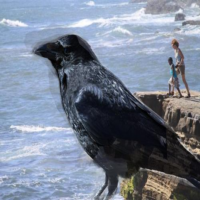

In [ ]:
to_image = torchvision.transforms.ToPILImage()
to_image(next(iter(test_loader))[0].squeeze()[0])

In [ ]:
next(iter(test_loader))[0].squeeze()

tensor([[[[0.2675, 0.3391, 0.3197,  ..., 0.2923, 0.4666, 0.3925],
          [0.3006, 0.3665, 0.3618,  ..., 0.3159, 0.5047, 0.3659],
          [0.2775, 0.3658, 0.3619,  ..., 0.3267, 0.3394, 0.2482],
          ...,
          [0.0819, 0.1514, 0.2360,  ..., 0.7976, 0.5740, 0.1655],
          [0.2273, 0.1637, 0.1929,  ..., 0.9357, 0.5133, 0.1262],
          [0.3615, 0.3426, 0.2790,  ..., 0.9345, 0.4706, 0.1360]],

         [[0.2448, 0.3075, 0.2795,  ..., 0.3262, 0.4785, 0.3932],
          [0.2793, 0.3362, 0.3227,  ..., 0.3427, 0.5138, 0.3694],
          [0.2586, 0.3378, 0.3253,  ..., 0.3566, 0.3528, 0.2537],
          ...,
          [0.1546, 0.2236, 0.3138,  ..., 0.7818, 0.5257, 0.1149],
          [0.3329, 0.2608, 0.2852,  ..., 0.9235, 0.4622, 0.0714],
          [0.4940, 0.4593, 0.3864,  ..., 0.9179, 0.4147, 0.0765]],

         [[0.3275, 0.3833, 0.3433,  ..., 0.2984, 0.4811, 0.4223],
          [0.3539, 0.4053, 0.3807,  ..., 0.3661, 0.5474, 0.3906],
          [0.3204, 0.3953, 0.3687,  ..., 0